# People Detection and Crowd-sizing

## import libraries

In [17]:
import os, random, zipfile, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab import files
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from ultralytics import YOLO
import random
from typing import List, Dict

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### EDA for People Detection Dataset

In [21]:
# Reproducibility
random.seed(42)
np.random.seed(42)


# Path Setups
root = Path("/content")
project_root = root / "people_detection"
data_root = project_root / "data"
image_exts = (".jpg", ".jpeg", ".png")

In [22]:

# Clean old subsets for safe reruns
if project_root.exists():
  print("Removing old subset")
  shutil.rmtree(project_root)
project_root.mkdir(parents = True, exist_ok = True)

Removing old subset


## download dataset

In [23]:
download_path = kagglehub.dataset_download("adilshamim8/people-detection")

print("Path to dataset files:", download_path)

Using Colab cache for faster access to the 'people-detection' dataset.
Path to dataset files: /kaggle/input/people-detection


In [24]:
# Copy dataset into your project data directory
(project_root / "data").mkdir(parents=True, exist_ok=True)

target_splits = ['train', 'valid', 'test']

for split_name in target_splits:
    source_dir = Path(download_path) / split_name / split_name # Corrected to include nested split_name
    destination_dir = data_root / split_name

    if source_dir.exists():
        # Remove existing destination directory to ensure a fresh copy
        if destination_dir.exists():
            shutil.rmtree(destination_dir)
            print(f"Removed existing '{destination_dir}' for a fresh copy.")

        shutil.copytree(source_dir, destination_dir)
        print(f"Copied '{source_dir}' to '{destination_dir}'.")
    else:
        print(f"Source directory '{source_dir}' does not exist. Skipping.")


print("Dataset copied successfully")

Copied '/kaggle/input/people-detection/train/train' to '/content/people_detection/data/train'.
Copied '/kaggle/input/people-detection/valid/valid' to '/content/people_detection/data/valid'.
Copied '/kaggle/input/people-detection/test/test' to '/content/people_detection/data/test'.
Dataset copied successfully


## Get subset of train dataset
- split the subset data to train/val set

In [25]:
# Get a subset with 20% of the data with maximum images set to 3000
def collect_images(base: Path):
  return sorted([p for p in base.rglob("*") if p.suffix.lower() in image_exts])

train_images = collect_images(data_root / "train")
print(f"Total images found: {len(train_images)}")

Total images found: 15210


In [26]:
subset_fraction = 0.20
n_target = int(len(train_images) * subset_fraction)
n_max = 3000
n_subset = min(n_target, n_max)
print(f"Using {n_subset} images (20% of the total data, capped at {n_max})")

subset_images = random.sample(train_images, n_subset)
random.shuffle(subset_images)
split_idx = int(len(subset_images) * 0.8)
subset_train_images = subset_images[:split_idx]
subset_val_images = subset_images[split_idx:]
print(f"Subset split: {len(subset_train_images)} train / {len(subset_val_images)} val")


Using 3000 images (20% of the total data, capped at 3000)
Subset split: 2400 train / 600 val


In [27]:
subset_data_path = data_root / "subset"
subset_data_path.mkdir(parents = True, exist_ok = True)

images_train = subset_data_path / "images/train"
images_val = subset_data_path / "images/val"
labels_train = subset_data_path / "labels/train"
labels_val = subset_data_path / "labels/val"

for p in [images_train, images_val, labels_train, labels_val]:
  p.mkdir(parents = True, exist_ok = True)

def safe_link(src: Path, dst: Path):
  try:
    os.symlink(src, dst)
  except:
    shutil.copy(src, dst)

for img in subset_train_images:
  safe_link(img, images_train / img.name)

for img in subset_val_images:
  safe_link(img, images_val / img.name)

print("Subset images copied")

Subset images copied


## Pseudo-label dataset if labels doesnt exist

In [28]:
# Generate pseudo labels using pretrained YOLOv8n
train_labels = list(labels_train.glob("*.txt"))
val_labels = list(labels_val.glob("*.txt"))
print(f"Train labels: {len(train_labels)}")
print(f"Val labels: {len(val_labels)}")

if len(train_labels) == 0 and len(val_labels) == 0:
    print("No labels found. YOLOv8n will generate pseudo labels.")
    base_model = YOLO("yolov8n.pt")

    def pseudo_label_stream(model, img_folder: Path, label_folder: Path, conf=0.35, iou=0.5, imgsz=640):
      label_folder.mkdir(parents = True, exist_ok = True)

      results = model.predict(
          source = str(img_folder),
          imgsz = imgsz,
          conf = conf,
          iou = iou,
          stream = True,
          verbose = False,
          max_det = 200
      )

      n_files = 0
      for r in results:
        img_path = Path(r.path)
        h, w = r.orig_shape
        lines = []

        if r.boxes is not None:
          for b in r.boxes:
            if int(b.cls.item()) != 0:
              continue

            x1, y1, x2, y2 = b.xyxy[0].tolist()
            cx = ((x1 + x2) / 2.0) / w
            cy = ((y1 + y2) / 2.0) / h
            bw = (x2 - x1) / w
            bh = (y2 - y1) / h
            lines.append(f"0 {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

        if lines:
          label_path = label_folder / f"{img_path.stem}.txt"
          with open(label_path, "w") as f:
            f.write("\n".join(lines))
          n_files += 1

      print(f"Pseudo labels written in {label_folder}: {n_files}")

    pseudo_label_stream(base_model, images_train, labels_train)
    pseudo_label_stream(base_model, images_val, labels_val)
else:
  print("Pseudo labels already generated.")

print("Pseudo labeling done.")

Train labels: 0
Val labels: 0
No labels found. YOLOv8n will generate pseudo labels.
Pseudo labels written in /content/people_detection/data/subset/labels/train: 1965
Pseudo labels written in /content/people_detection/data/subset/labels/val: 500
Pseudo labeling done.


# EDA

## count the images and corresponding labels per split

In [19]:
image_exts = {".jpg", ".jpeg", ".png"}

# Define root paths for images and labels based on previously defined subset_data_path
images_root = subset_data_path / "images"
labels_root = subset_data_path / "labels"

# Define the 'splits' dictionary mapping split names to their image directory paths.
# This variable 'splits' will be used in subsequent cells for iteration and path access.
splits = {
    "train": images_root / "train",
    "val": images_root / "val"
}

# Define a mapping for label directories for convenience within this cell and consistent access.
label_dirs = {
    "train": labels_root / "train",
    "val": labels_root / "val"
}

def list_images(split_name: str) -> List[Path]:
    """Lists image files for a given split."""
    if split_name not in splits:
        raise ValueError(f"Unknown split name: {split_name}")
    return sorted(p for p in splits[split_name].iterdir() if p.suffix.lower() in image_exts)

def label_path(img_path: Path, split_name: str) -> Path:
    """Returns the path to the label file for a given image and split."""
    if split_name not in label_dirs:
        raise ValueError(f"Unknown split name: {split_name}")
    return label_dirs[split_name] / (img_path.stem + ".txt")

counts = []

for split_name in splits.keys(): # Iterate over the split names ('train', 'val')
    imgs = list_images(split_name)
    lbls = sorted(label_dirs[split_name].glob("*.txt"))
    counts.append({"split": split_name, "images": len(imgs), "labels": len(lbls)})

display(pd.DataFrame(counts))

split  images  labels
0  train    2400    1965
1    val     600     500

##

## Check for missing/extra labels and verify images open

In [36]:
missing_labels = []
extra_labels = []
corrupt_images = []

for split in splits:
    imgs = list_images(split)
    img_names = {p.stem for p in imgs}
    lbl_names = {p.stem for p in (labels_root / split).glob("*.txt")}

    missing_labels.extend(sorted(img_names - lbl_names))
    extra_labels.extend(sorted(lbl_names - img_names))

    for p in imgs:
        try:
            with Image.open(p) as im:
                im.verify()
        except Exception as e:
            corrupt_images.append((p, str(e)))

print(f"Missing labels: {len(missing_labels)}")
print(f"Extra labels: {len(extra_labels)}")
print(f"Corrupt images: {len(corrupt_images)}")

if missing_labels:
    print("Examples:", missing_labels[:5])
if extra_labels:
    print("Examples:", extra_labels[:5])
if corrupt_images:
    print("Examples:", corrupt_images[:2])

Missing labels: 535
Extra labels: 0
Corrupt images: 0
Examples: ['000192_r_jpg.rf.ebecfb493d02cec37f05600fbf674cee', '000229_jpg.rf.ca7d72dafe299d5c6586e38fbc749812', '0005340_jpg.rf.42cb98ed2f9006d41e323c4340eee37b', '001054_jpg.rf.aedf78ebd97e34596c5e543accb6d265', '002287_jpg.rf.9517458b6fd954156c86f5567ef5ddd6']


## Bounding box analysis

In [37]:
# Parse YOLO labels into a DataFrame for box-level analysis

records: List[Dict] = []

for split in splits:
    for img_path in list_images(split):
        lbl_path = label_path(img_path, split)
        with Image.open(img_path) as im:
            w, h = im.size
        if lbl_path.exists():
            for line in lbl_path.read_text().strip().splitlines():
                if not line.strip():
                    continue
                cls, xc, yc, bw, bh = map(float, line.split())
                records.append({
                    "split": split,
                    "image": img_path.name,
                    "class_id": int(cls),
                    "img_w": w,
                    "img_h": h,
                    "box_w_norm": bw,
                    "box_h_norm": bh,
                    "box_w_px": bw * w,
                    "box_h_px": bh * h,
                    "box_area_pct": bw * bh * 100,
                    "box_aspect": bw / bh if bh > 0 else np.nan,
                })

boxes_df = pd.DataFrame.from_records(records)
print(boxes_df.shape)
boxes_df.head()

(10622, 11)


split                                              image  class_id  img_w  \
0  train  000001_jpg.rf.896508b6d1874829ee5d32d736158d29...         0   1672   
1  train  000001_jpg.rf.896508b6d1874829ee5d32d736158d29...         0   1672   
2  train  000001_jpg.rf.896508b6d1874829ee5d32d736158d29...         0   1672   
3  train  000001_jpg.rf.896508b6d1874829ee5d32d736158d29...         0   1672   
4  train  000001_jpg.rf.896508b6d1874829ee5d32d736158d29...         0   1672   

   img_h  box_w_norm  box_h_norm    box_w_px   box_h_px  box_area_pct  \
0    940    0.101802    0.331260  170.212944  311.38440      3.372293   
1    940    0.041421    0.166568   69.255912  156.57392      0.689941   
2    940    0.041703    0.115292   69.727416  108.37448      0.480802   
3    940    0.041585    0.221792   69.530120  208.48448      0.922322   
4    940    0.047669    0.232275   79.702568  218.33850      1.107232   

   box_aspect  
0    0.307318  
1    0.248673  
2    0.361716  
3    0.187495  
4    0.205227

## Images analysis

In [31]:
# Image-level stats (size, aspect) to guide resize policy

image_rows = []
for split in splits:
    for img_path in list_images(split):
        with Image.open(img_path) as im:
            w, h = im.size
        image_rows.append({
            "split": split,
            "image": img_path.name,
            "width": w,
            "height": h,
            "aspect": w / h,
        })

images_df = pd.DataFrame(image_rows)
print(images_df.describe())

             width       height       aspect
count  3000.000000  3000.000000  3000.000000
mean    912.331667   621.773333     1.409858
std     651.383892   382.679686     0.332978
min     191.000000   165.000000     0.382000
25%     486.000000   375.000000     1.211881
50%     560.000000   496.000000     1.336898
75%    1234.000000   712.000000     1.777778
max    4624.000000  3468.000000     2.777778


## Visualize image with bounding box

003868_jpg.rf.c2a7546793eaa92279ba4973048435bb.jpg


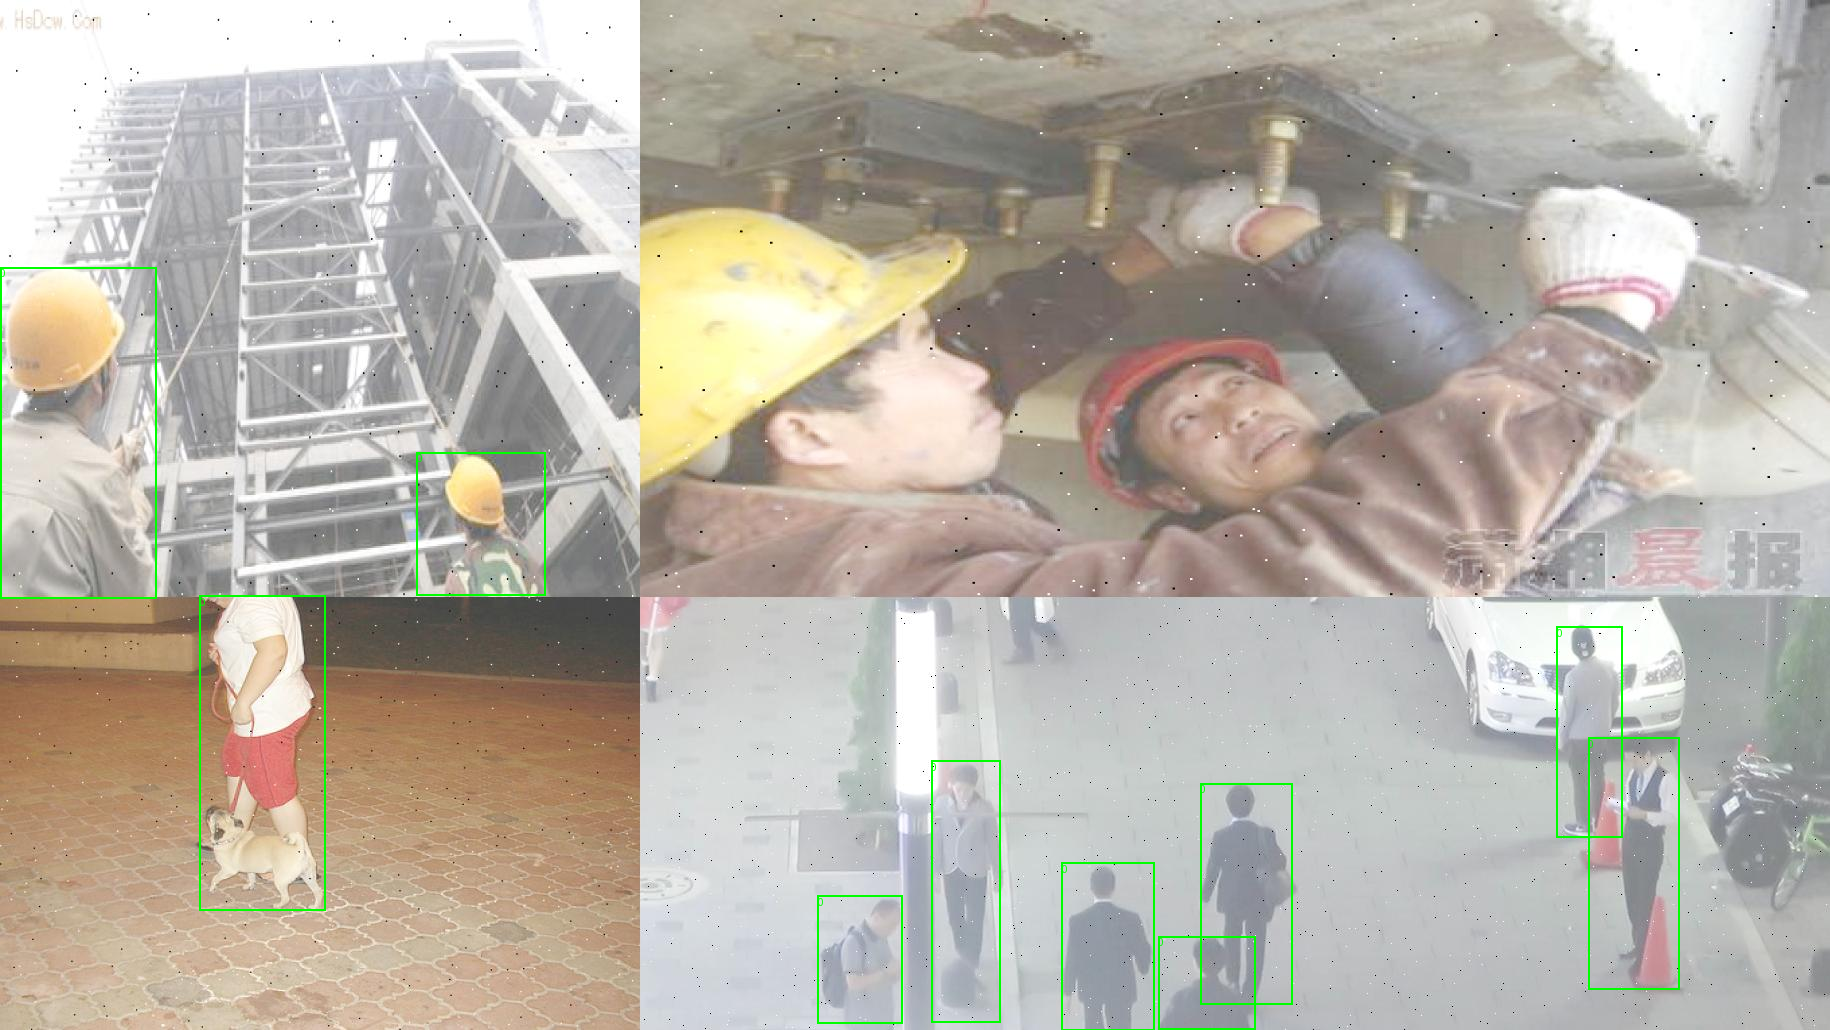

2009_003123_jpg.rf.d6131ac7ac69b2b4e9ce81d1e6d32055.jpg


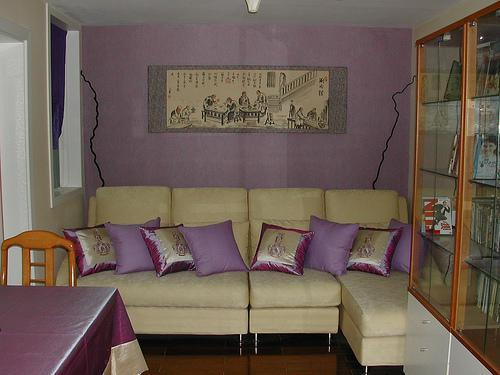

2010_005245_jpg.rf.297fd1702d986faf794cd097f42ddd14.jpg


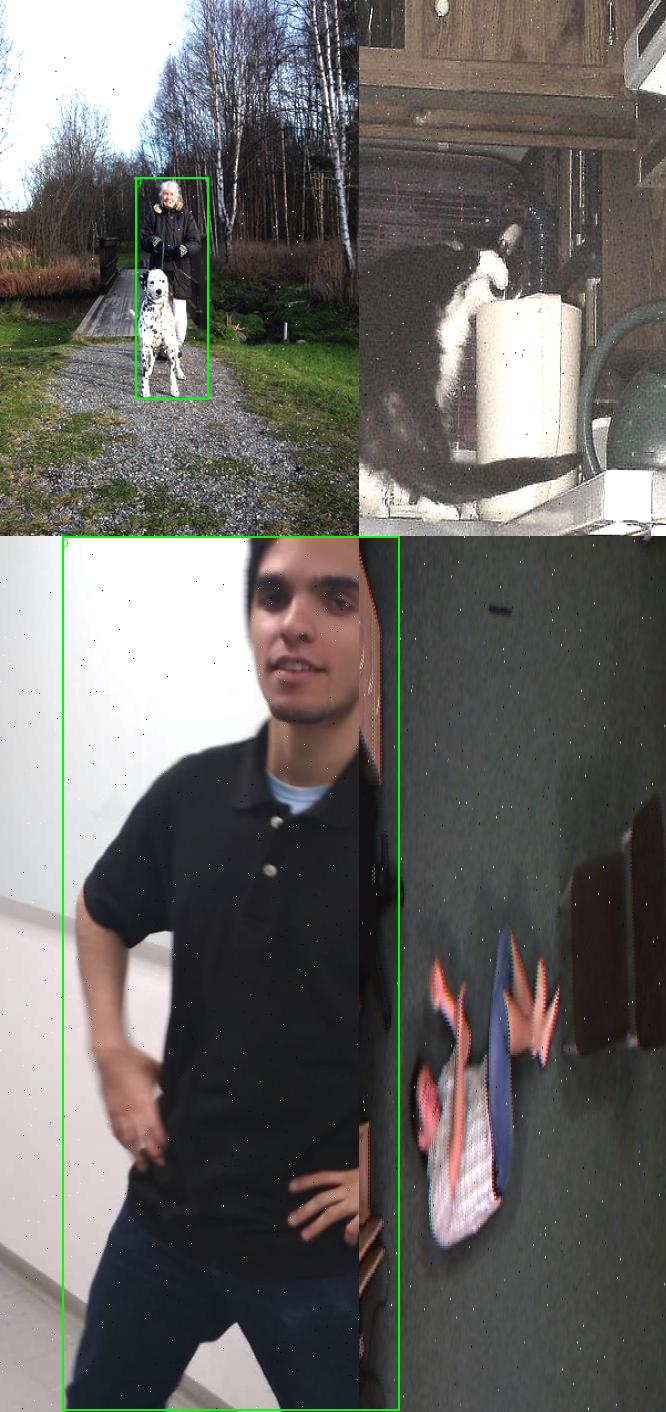

2008_003958_jpg.rf.48549c8328e8daebd8b460e81bc114f1.jpg


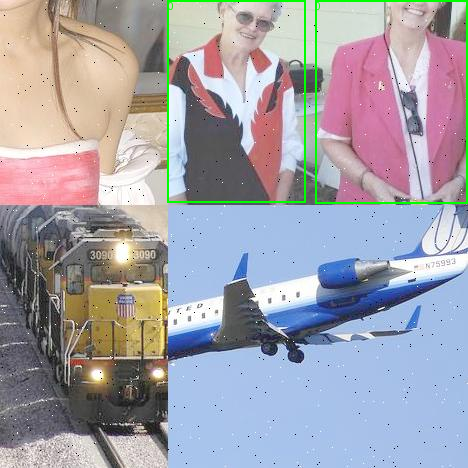

In [35]:
# Visual sanity check: show a few images with boxes overlaid

def draw_boxes(image_path: Path, labels_path: Path):
    im = Image.open(image_path).convert("RGB")
    w, h = im.size
    draw = ImageDraw.Draw(im)
    if labels_path.exists():
        for line in labels_path.read_text().strip().splitlines():
            if not line.strip():
                continue
            cls, xc, yc, bw, bh = map(float, line.split())
            box_w, box_h = bw * w, bh * h
            x0 = (xc - bw / 2) * w
            y0 = (yc - bh / 2) * h
            x1 = x0 + box_w
            y1 = y0 + box_h
            draw.rectangle([x0, y0, x1, y1], outline="lime", width=2)
            draw.text((x0, y0), f"{int(cls)}", fill="lime")
    return im

num_show = 4
all_imgs = [p for p in images_root.glob("**/*") if p.suffix.lower() in image_exts]
sample = random.sample(all_imgs, k=min(num_show, len(all_imgs)))
for img_path in sample:
    split = img_path.parent.name
    lbl_path = label_path(img_path, split) if split in splits else None
    if lbl_path is None:
        continue
    annotated = draw_boxes(img_path, lbl_path)
    print(img_path.name)
    display(annotated)
